In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS
from src.neural_networks.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier


import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data_load, test_data1, ignore = load_cv_data(1, features_names_dict)

ignore, test_data2, ignore = load_cv_data(2, features_names_dict)

ignore, test_data3_original, ignore = load_cv_data(3, features_names_dict)

test_data1 = test_data1.batch(test_data1.cardinality())

test_data2 = test_data2.batch(test_data2.cardinality())

test_data3 = test_data3_original.batch(test_data3_original.cardinality())

train_data_load = train_data_load.batch(32)

In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_3'

filepath2 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    emos_base = EMOS(pickle.load(f))

with open(filepath2, 'rb') as f:
    emos_weight = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [5]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_tn_3'

with open(filepath, 'rb') as f:
    emos165 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_3'

with open(filepath, 'rb') as f:
    emos24 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_ln_3'

with open(filepath, 'rb') as f:
    emos66 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/pareto_front_82_3'

with open(filepath, 'rb') as f:
    emos82 = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Log Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [6]:
best_models = {'Model 165': emos165, "Model 24": emos24, 'Model 66': emos66, 'Model 82': emos82}

model_climatology = {'Model 165': emos165, 'Model 82': emos82, 'Base Emos': emos_base}

In [7]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [8]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

us1 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_1', train_data_load)

us2 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_2', train_data_load)

us3 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_3', train_data_load)

us4 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_4', train_data_load)

us5 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_5', train_data_load)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

is1 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_1', train_data_load)

is2 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_2', train_data_load)

is3 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_3', train_data_load)

is4 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_4', train_data_load)

is5 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_5', train_data_load)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


In [10]:
is_us_models = {
    'is1': is1,
    'is2': is2,
    'is3': is3,
    'is4': is4,
    'is5': is5,
    'us1': us1,
    'us2': us2,
    'us3': us3,
    'us4': us4,
    'us5': us5
}

### Constraint for Mixture Linear Model

For the mixture linear I defined the weight by 

$w = \sigma(\alpha + \beta X_w)$

where $\sigma$ is the sigmoid function. I now set the following contraints:

$\alpha \in [4,12] \quad\text{and} \quad\beta \in [-6,-0.6]$

The constraint is implemented with projection.

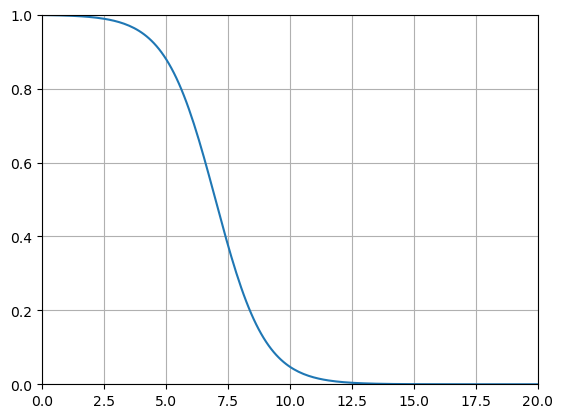

In [11]:
alpha = 7
beta = -1
x = np.linspace(0, 20, 200)

y = 1 / (1 + np.exp(-(alpha + beta * x)))
plt.plot(x, y)
plt.xlim(0,20)
plt.ylim(0,1)
plt.grid()
plt.show()

### Climatology for low wind speeds

In the plots of Daniel, he starts at 1 instead of 0.

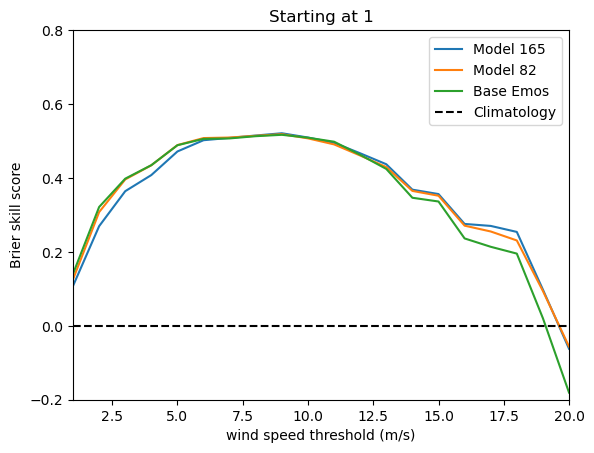

In [12]:
title = 'Starting at 1'
ylim = [-0.2, 0.8]
values = np.arange(1, 21, 1)
make_brier_skill_plot_tf(climatology, model_climatology, test_data3, values, name_base_model='Climatology', ylim=ylim, title=title)

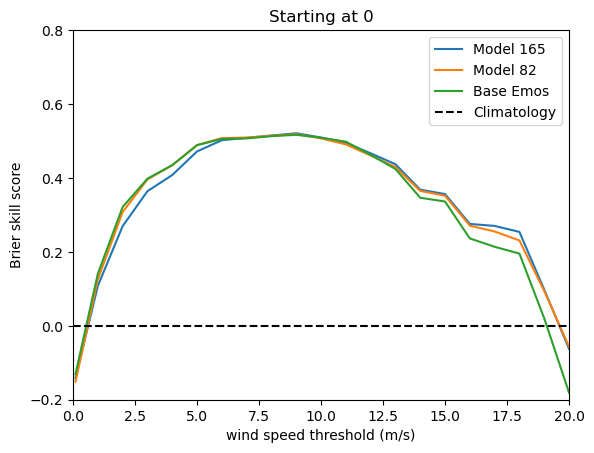

In [13]:
title = 'Starting at 0'
ylim = [-0.2, 0.8]
values = np.arange(0.0,21.0,1.0)
values[0] = 0.1
make_brier_skill_plot_tf(climatology, model_climatology, test_data3, values, name_base_model='Climatology', ylim=ylim, title=title)

### Fixed Initialization

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


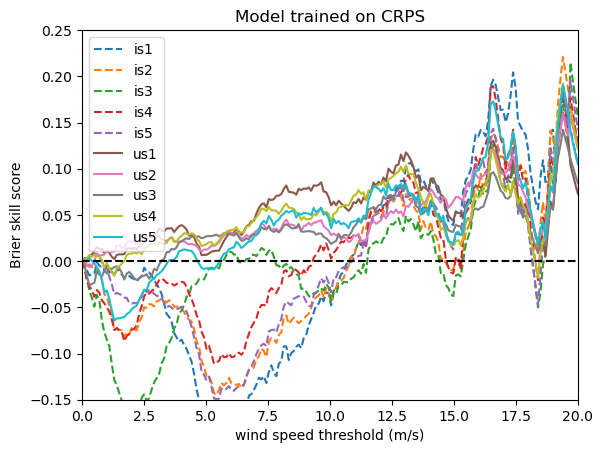

In [14]:
values = np.linspace(0, 20, 200)

brier_base_model = get_brier_scores_tf(emos_base, test_data3, values)
for model in is_us_models:
    brier_scores = get_brier_scores_tf(is_us_models[model], test_data3, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if model[:2] == 'us':
        plt.plot(values, brier_skill_scores, label = model)
    else:
        plt.plot(values, brier_skill_scores, label = model, linestyle='--')

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('wind speed threshold (m/s)')
plt.ylabel('Brier skill score')
plt.xlim(0, 20)
plt.ylim(-0.15, 0.25)
plt.title("Model trained on CRPS")
plt.legend()
plt.show()